# Create Quadtree Grid for McDonald Valley Problem

use GRIDGEN on the fly

## Load Modules and Setup Notebook

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

from flopy.utils.gridgen import Gridgen 

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/shua784/anaconda3/lib/python3.6/site-packages/flopy
3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.4
matplotlib version: 2.0.2
flopy version: 3.2.12


In [2]:
# set the path to data needed for this problem
datapath = '../data/mcdonaldvalley-unstructured'
assert os.path.isdir(datapath)

# executable name
exe_name = os.path.abspath('../bin/mf6')
assert os.path.isfile(exe_name)

# model workspace
ws = './data/ex06-quadtree'

## Create Base Grid

In [3]:
nlay = 5
nrow = 40
ncol = 25
delr = 500.
delc = 500.
top = 100.
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[0] = -5.
botm[1] = -50
botm[2] = -51
botm[3] = -100
fname = os.path.join(datapath, 'bottom.csv')
botm[4] = np.loadtxt(fname, delimiter=',')
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

## Create Features for Grid Refinement

In [4]:
def get_circle(x, y, r):
    phi = np.arange(0, 2 * np.pi, 0.01)
    return x + r * np.cos(phi), y + r * np.sin(phi)

In [5]:
# wells
well_list = [('Reilly', 6, 15, -67000), 
             ('Virginia City(1)', 35, 16, -268000), 
             ('Virginia City(2)', 33, 6, -268000)]

well_pts = []
for name, row, col, Q in well_list:
    x = col * delr - 0.5 * delr
    y = nrow * delc - row * delc + 0.5 * delc
    print(name, x, y, Q)
    well_pts.append((x, y))
    
r = 1000
well_circles = []
for x, y in well_pts:
    xlist, ylist = get_circle(x, y, r)
    circle = []
    for i in range(xlist.shape[0]):
        circle.append((xlist[i], ylist[i]))
    well_circles.append(circle)

Reilly 7250.0 17250.0 -67000
Virginia City(1) 7750.0 2750.0 -268000
Virginia City(2) 2750.0 3750.0 -268000


In [6]:
# river
eps = 0.01
river = [(8.5 * delr - eps, 0), (8.5 * delr - eps, 18 * delc)]
for x, y in river:
    print(x, y)

4249.99 0
4249.99 9000.0


In [7]:
# lake
fname = os.path.join(datapath, 'lake_poly.dat')
lake_pts = np.loadtxt(fname)
lake_poly = []
for x, y in lake_pts:
    lake_poly.append((x, y))

## Build the Grid

In [8]:
gridgen_ws = os.path.join(ws, '_gridgen')
g = Gridgen(dis, model_ws=gridgen_ws, exe_name='../bin/gridgen')

rflist = []

#g.add_refinement_features(well_pts, 'point', 3, range(nlay))
#rflist.append(os.path.join(gridgen_ws, 'rf0'))
g.add_refinement_features([well_circles], 'polygon', 3, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf0'))

g.add_refinement_features([[lake_poly]], 'polygon', 1, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf1'))

g.add_refinement_features([[river]], 'line', 2, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf2'))

g.build(verbose=False)

## Plot the Gridgen Input

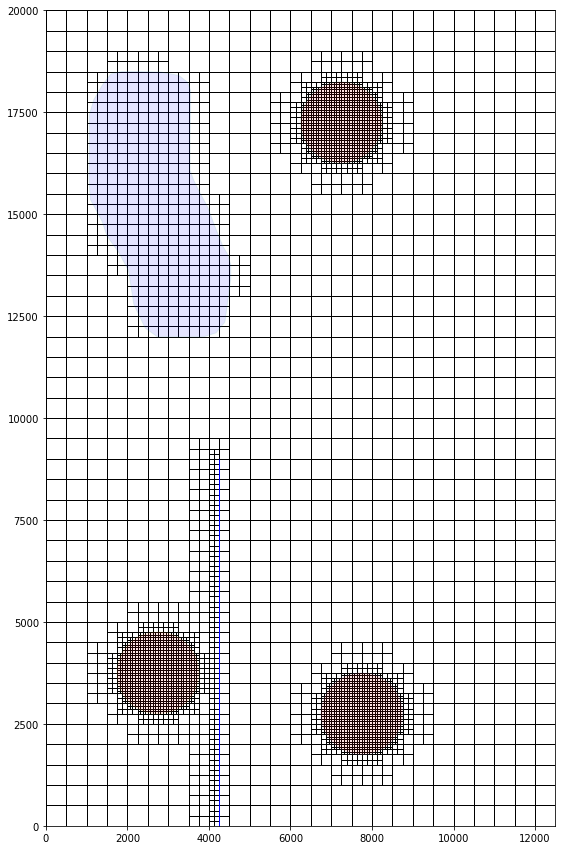

In [9]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
g.plot()
flopy.plot.plot_shapefile(rflist[0], ax=ax, facecolor='red', alpha=0.1)
flopy.plot.plot_shapefile(rflist[1], ax=ax, facecolor='blue', alpha=0.1)
flopy.plot.plot_shapefile(rflist[2], ax=ax, edgecolor='blue', linewidth=1)

## Retrieve DISV Information

In [10]:
gridprops_disv = g.get_gridprops_disv()
#gridprops_disv

## Intersect the Grid with the Property Arrays

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None


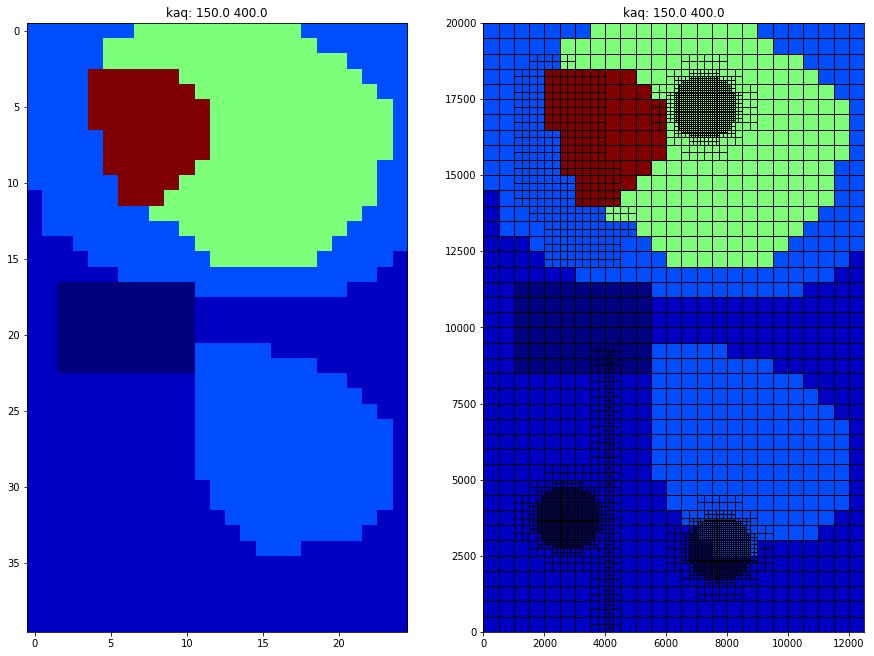

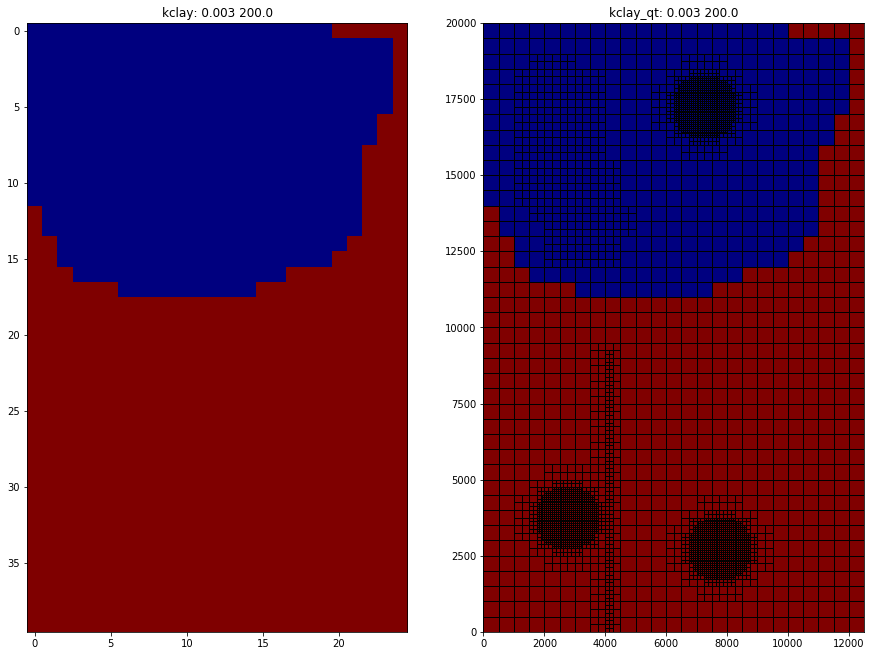

In [11]:
ncpl = gridprops_disv['ncpl']
cellxy = np.empty((ncpl, 2), dtype=np.float)
for n in range(ncpl):
    x, y = g.get_center(n)
    cellxy[n, 0] = x
    cellxy[n, 1] = y

fname = os.path.join(datapath, 'k_aq.csv')
kaq = np.loadtxt(fname, delimiter=',')
kaq_qt = ms.sr.interpolate(kaq, cellxy)

from flopy.utils.gridgen import read1d
kclay = np.empty((dis.nrow * dis.ncol), dtype=np.float)
fname = os.path.join(datapath, 'k_clay.txt')
f = open(fname, 'r')
kclay = read1d(f, kclay).reshape((dis.nrow, dis.ncol))
kclay_qt = ms.sr.interpolate(kclay, cellxy)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.imshow(kaq, vmin=kaq.min(), vmax=kaq.max(), cmap='jet')
ax.set_title('kaq: {} {}'.format(kaq.min(), kaq.max()))
ax = fig.add_subplot(1, 2, 2, aspect='equal')
g.plot(ax=ax, a=kaq_qt, vmin=kaq.min(), vmax=kaq.max(), cmap='jet')
ax.set_title('kaq: {} {}'.format(kaq_qt.min(), kaq_qt.max()))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.imshow(kclay, vmin=kclay.min(), vmax=kclay.max(), cmap='jet')
ax.set_title('kclay: {} {}'.format(kclay.min(), kclay.max()))
ax = fig.add_subplot(1, 2, 2, aspect='equal')
g.plot(ax=ax, a=kclay_qt, vmin=kclay_qt.min(), vmax=kclay_qt.max(), cmap='jet')
ax.set_title('kclay_qt: {} {}'.format(kclay_qt.min(), kclay_qt.max()))

## Intersect the Features with the Grid

In [12]:
well_intersect = g.intersect(well_pts, 'point', 0)
print(well_intersect)
print(well_intersect.dtype)

[( 697, 0, 0) (3787, 1, 1) (2701, 2, 2)]
(numpy.record, [('nodenumber', '<i8'), ('pointid', '<i8'), ('SHAPEID', '<i8')])


In [13]:
lake_intersect = g.intersect([[lake_poly]], 'polygon', 0)
print(lake_intersect)
print(lake_intersect.dtype)
print('number of lake cells: {}'.format(lake_intersect.shape))

[( 104, 0, 6.25000e+04, 0) ( 103, 0, 6.25000e+04, 0)
 ( 107, 0, 6.25000e+04, 0) ( 101, 0, 6.25000e+04, 0)
 ( 102, 0, 6.25000e+04, 0) ( 110, 0, 6.25000e+04, 0)
 ( 113, 0, 6.25000e+04, 0) ( 266, 0, 6.25000e+04, 0)
 ( 253, 0, 6.25000e+04, 0) ( 252, 0, 6.25000e+04, 0)
 ( 268, 0, 6.25000e+04, 0) ( 548, 0, 6.25000e+04, 0)
 ( 550, 0, 6.25000e+04, 0) ( 564, 0, 6.25000e+04, 0)
 ( 566, 0, 6.25000e+04, 0) ( 864, 0, 6.25000e+04, 0)
 ( 866, 0, 6.25000e+04, 0) ( 880, 0, 6.25000e+04, 0)
 ( 882, 0, 6.25000e+04, 0) (1162, 0, 6.25000e+04, 0)
 (1164, 0, 6.25000e+04, 0) (1178, 0, 6.25000e+04, 0)
 (1180, 0, 6.25000e+04, 0) (1316, 0, 6.25000e+04, 0)
 (1318, 0, 6.25000e+04, 0) (1332, 0, 6.25000e+04, 0)
 (1387, 0, 6.25000e+04, 0) (1334, 0, 6.25000e+04, 0)
 (1368, 0, 6.25000e+04, 0) (1373, 0, 6.25000e+04, 0)
 (1434, 0, 6.25000e+04, 0) (1389, 0, 6.25000e+04, 0)
 (1417, 0, 6.25000e+04, 0) (1419, 0, 6.25000e+04, 0)
 (1436, 0, 6.25000e+04, 0) (1464, 0, 6.25000e+04, 0)
 (1469, 0, 6.25000e+04, 0) (1485, 0, 6.25000e+

In [14]:
river_intersect = g.intersect([[river]], 'line', 0)
#print(river_intersect)
print(river_intersect.dtype)
print('number of river cells: {}'.format(river_intersect.shape))

rivspd = []
rbot = -2.
for i, icell in enumerate(river_intersect.nodenumber):
    cond = 1.e5
    length = river_intersect['length'][i]
    distance = (river_intersect['starting_distance'][i] +
                river_intersect['ending_distance'][i]) / 2.
    stage = 0 + distance / (18 * delc)
    cond = cond / delc * length
    rivspd.append([(0, icell), stage, cond, rbot])

(numpy.record, [('nodenumber', '<i8'), ('arcid', '<i8'), ('length', '<i8'), ('starting_distance', '<i8'), ('ending_distance', '<i8'), ('SHAPEID', '<i8')])
number of river cells: (72,)


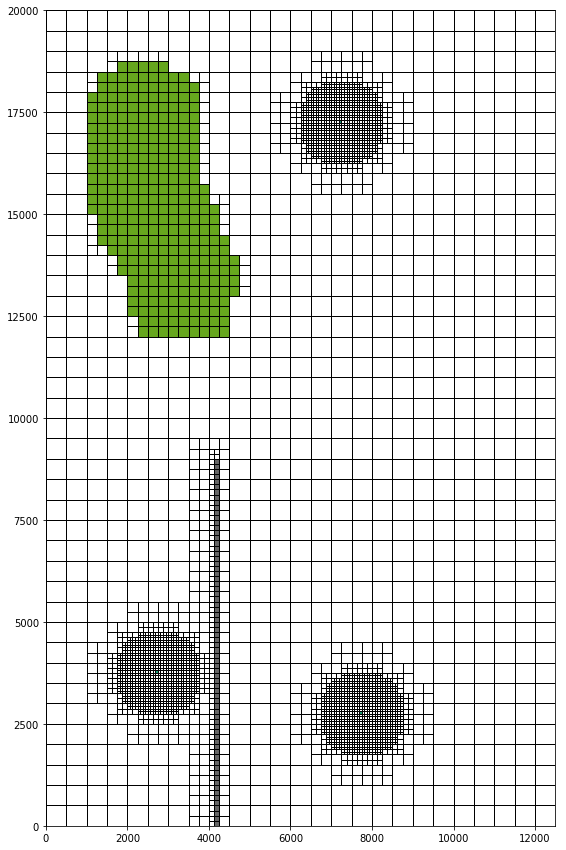

In [15]:
ibd = np.zeros((g.nodelay[0]), dtype=np.int)
ibd[well_intersect.nodenumber] = 1
ibd[lake_intersect.nodenumber] = 2
ibd[river_intersect.nodenumber] = 3

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pc = g.plot(ax=ax, a=ibd, masked_values=[0])

## Build the Model

In [16]:
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name=exe_name)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, save_flows=True)
dis = flopy.mf6.ModflowGwfdisv(gwf, **gridprops_disv)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              xt3doptions=True, save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq_qt, kaq_qt, kclay_qt, kaq_qt, kaq_qt],
                              k33=[0.25 * kaq_qt, 0.25 * kaq_qt, kclay_qt, 0.25 * kaq_qt, 0.25 * kaq_qt])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[((0, rec[0]), 11.) for rec in lake_intersect])
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
oc = flopy.mf6.ModflowGwfoc(gwf, 
                            head_filerecord=name + '.hds', 
                            budget_filerecord=name + '.bud',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 293 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 72 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geologic

(True, [])

## Post-Process the Results

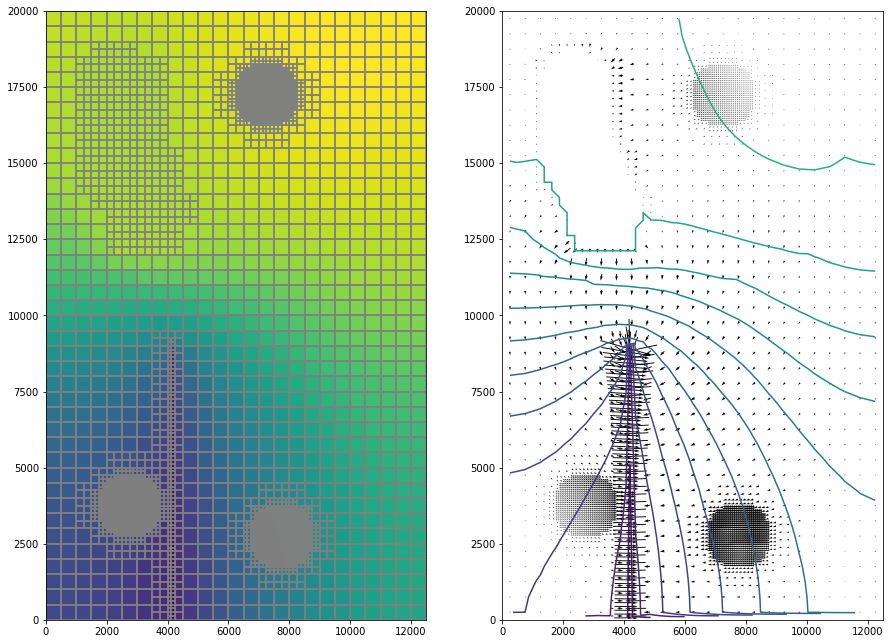

In [17]:
from flopy.utils.binaryfile import HeadFile, CellBudgetFile
fname = os.path.join(ws, name + '.hds')
headobj = HeadFile(fname)
head = headobj.get_data()[:, 0, :]
fname = os.path.join(ws, name + '.bud')
budobj = CellBudgetFile(fname, precision='double')
spdis = budobj.get_data(text='DATA-SPDIS')

ilay = 0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.plot_array(head)
pmv.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.contour_array(head, levels=np.arange(20))
pmv.plot_specific_discharge(spdis)